## PDDD-PreTrain

#### Based i the pre-trained model revised in https://doi.org/10.34133/plantphenomics.0054
Xinyu Dong, Qi Wang, Qianding Huang, Qinglong Ge, Kejun Zhao ,Xingcai Wu, Xue Wu, Liang Lei, Gefei Hao

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Activation, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras import regularizers, models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import scipy
import os

import optuna
import wandb
import gc

2025-11-12 17:42:10.774372: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-12 17:42:10.774398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-12 17:42:10.775166: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-12 17:42:10.779750: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("TensorFlow is using the GPU \n", gpus)
else:
    print("No GPU detected.")
    
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

TensorFlow is using the GPU 
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-11-12 17:42:18.130255: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-12 17:42:18.137252: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-12 17:42:18.138050: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
os.makedirs("/workspace/Optuna-Trials/Plant-Pathology-Classificator-Conv2D-Trials", exist_ok = True)

In [4]:
gc.collect()
tf.keras.backend.clear_session()

In [5]:
from wandb.integration.keras import WandbMetricsLogger

wandb.require("core")
wandb.login()

wandb: WARNING `wandb.require('core')` is a no-op as it is now the default behavior.
wandb: Currently logged in as: emmdaz (emmdaz-zzz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
# Carga de los datos 

df = pd.read_csv("/tf/Plant-Pathology-Classificator-Old/plant-pathology-2020-/train.csv")
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [7]:
import os

df["label"] = df[["healthy", "multiple_diseases", "rust", "scab"]].idxmax(axis=1)

df["filepath"] = df['image_id'].apply(lambda x: os.path.join("/tf/Plant-Pathology-Classificator-Old/plant-pathology-2020-/images", f'{x}.jpg'))

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_temp = train_test_split(df, test_size = 0.5, stratify = df["label"], random_state = 4)

X_test, X_val = train_test_split(X_temp, test_size = 0.4, stratify = X_temp["label"], random_state = 4)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 910
Validation size: 365
Test size: 546


In [9]:
def color_saturation_filter(img):
    
    # Convertir a uint8
    if img.dtype == np.float32 and img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)

    # Convertir RGB a HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
    h, s, v = cv2.split(hsv)

    # Rangos de matiz
    red_mask1 = (h < 10)
    red_mask2 = (h > 170)
    orange_yellow_mask = (h >= 10) & (h <= 30)
    green_mask = (h >= 35) & (h <= 85)
    cyan_blue_mask = (h >= 90) & (h <= 130)

    # Saturar rojo, naranja y amarillo
    s[red_mask1 | red_mask2 | orange_yellow_mask] *= 3.0

    # Disminuir tonos azules
    s[cyan_blue_mask] *= 0.7
    
    # Disminuir saturación del verde
    s[green_mask] *= 0.7   

    # Disminuir luminancia del verde
    v[green_mask] *= 0.85 

    # Recortar valores a [0,255]
    s = np.clip(s, 0, 255)
    v = np.clip(v, 0, 255)

    # Juntar y convertir en RGB
    hsv_mod = cv2.merge([h, s, v]).astype(np.uint8)
    rgb_mod = cv2.cvtColor(hsv_mod, cv2.COLOR_HSV2RGB)

    return rgb_mod.astype(np.float32)


In [10]:
def custom_preprocessing(img):

    img = color_saturation_filter(img)
    
    return img

In [11]:
datagen_train = ImageDataGenerator(
    preprocessing_function = custom_preprocessing,
    rescale = 1./255,
    rotation_range = 0.01 ,          
    width_shift_range = 0.02,      
    height_shift_range = 0.02,     
    shear_range = 0.2,            
    horizontal_flip = True,       
    vertical_flip = True,         
    brightness_range = (1.0, 1.12),
    channel_shift_range = 30.0,
    fill_mode = "nearest")

datagen_test_and_val = ImageDataGenerator(rescale = 1./255,
                                          preprocessing_function = custom_preprocessing,
                                          dtype = "float32")

In [12]:
train = datagen_train.flow_from_dataframe(
    dataframe = X_train,
    x_col = "filepath",
    y_col = "label",
    target_size = (256,256),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = True,
    seed = 4,
)

test = datagen_test_and_val.flow_from_dataframe(
    dataframe = X_test,
    x_col = "filepath",
    y_col = "label",
    target_size = (256,256),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False,
    seed = 4
)

val = datagen_test_and_val.flow_from_dataframe(
    dataframe = X_val,
    x_col = "filepath",
    y_col = "label",
    target_size = (256,256),
    batch_size = 32,
    shuffle = False,  
    seed = 4
)

Found 910 validated image filenames belonging to 4 classes.
Found 546 validated image filenames belonging to 4 classes.
Found 365 validated image filenames belonging to 4 classes.


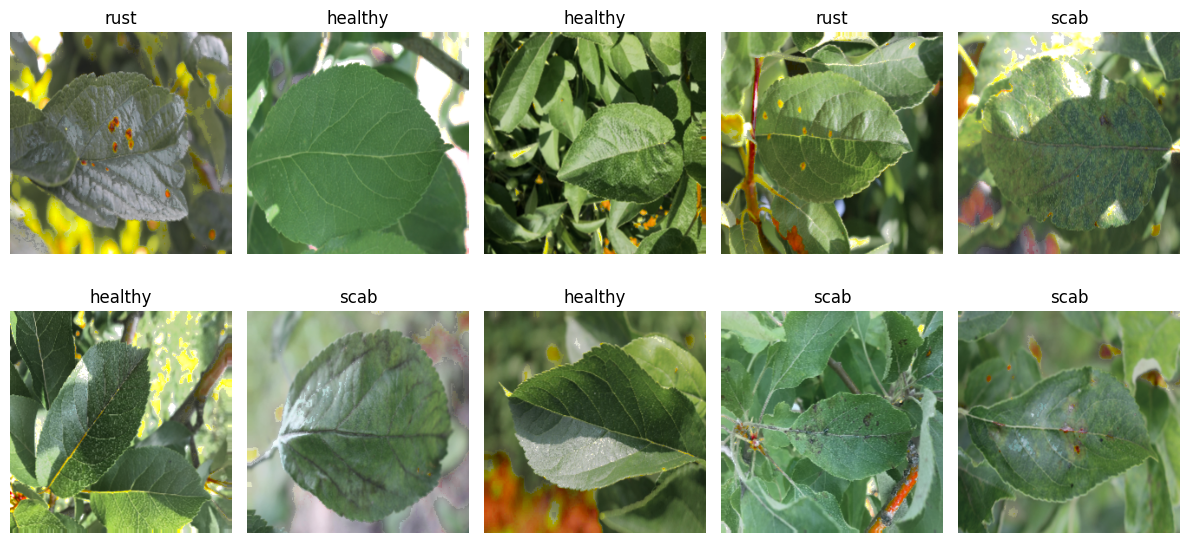

In [13]:
img, labels = next(train)

label_indices = np.argmax(labels, axis=1)
class_names = list(train.class_indices.keys())

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[i])
    plt.title(class_names[label_indices[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

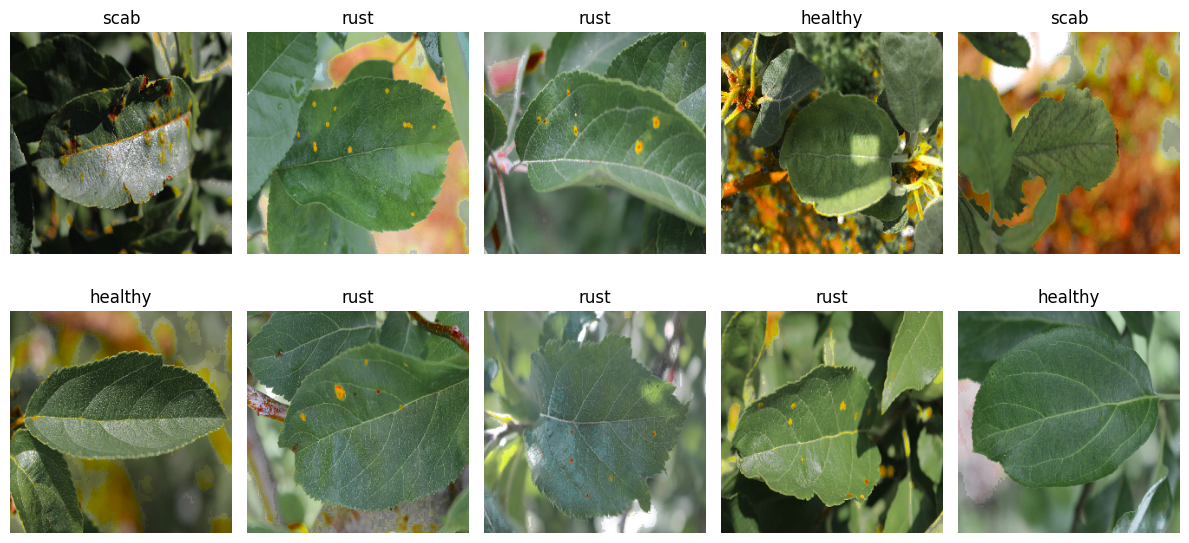

In [15]:
img, labels = next(val)

label_indices = np.argmax(labels, axis=1)
class_names = list(val.class_indices.keys())

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[i])
    plt.title(class_names[label_indices[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [16]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650, compute capability 7.5


2025-11-12 17:42:47.478275: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [17]:
import torch
import torchvision.models as models

model = models.resnet101(pretrained=False)

num_classes = 20
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)


state_dict = torch.load("/tf/Plant-Pathology-Classificator-Old/ResNet_101_ImageNet_plant-model-84.pth", map_location="cpu")
model.load_state_dict(state_dict)

model.fc = torch.nn.Identity() # Borrar última capa para exportar únicamente el extractor de características

model.eval()

# Conversión a .onnx

dummy_input = torch.randn(1, 3, 224, 224)

torch.onnx.export(
    model,
    dummy_input,
    "model.onnx",
    input_names=["input"],
    output_names=["features"],
    dynamic_axes={"input": {0: "batch"}, "features": {0: "batch"}},
)

import onnx
from onnx import numpy_helper

onnx_model = onnx.load("model.onnx")

def convert_model_to_fp32(model_path, output_path):
    model = onnx.load(model_path)

    for tensor in list(model.graph.initializer):
        arr = numpy_helper.to_array(tensor)
        if arr.dtype == "float16":
            print(f"Converting initializer {tensor.name} from float16 → float32")
            new_tensor = numpy_helper.from_array(arr.astype("float32"), name=tensor.name)
            model.graph.initializer.remove(tensor)
            model.graph.initializer.append(new_tensor)

    for value_info in list(model.graph.input) + list(model.graph.output):
        ttype = value_info.type.tensor_type
        if ttype.elem_type == 10:  # float16
            ttype.elem_type = 1     # float32

    for node in model.graph.node:
        for attr in node.attribute:

            if hasattr(attr, "t") and attr.t.data_type == 10:
                arr = numpy_helper.to_array(attr.t).astype("float32")
                attr.t.CopyFrom(numpy_helper.from_array(arr))

            if hasattr(attr, "tensors"):
                for t in attr.tensors:
                    if t.data_type == 10:
                        arr = numpy_helper.to_array(t).astype("float32")
                        t.CopyFrom(numpy_helper.from_array(arr))

    onnx.save(model, output_path)

convert_model_to_fp32("model.onnx", "model_all_fp32.onnx")

model_check = onnx.load("model_all_fp32.onnx")
float16_tensors = []
for t in model_check.graph.initializer:
    if numpy_helper.to_array(t).dtype == "float16":
        float16_tensors.append(t.name)

from onnx_tf.backend import prepare

onnx_model = onnx.load("model_all_fp32.onnx")
tf_rep = prepare(onnx_model)
tf_rep.export_graph("ResNet101_ImageNet_TF")
print("Finalizó conversión")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_504/959435864.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

INFO:tensorflow:Assets written to: ResNet101_ImageNet_TF/assets


INFO:tensorflow:Assets written to: ResNet101_ImageNet_TF/assets
INFO:absl:Writing fingerprint to ResNet101_ImageNet_TF/fingerprint.pb


Finalizó conversión


In [18]:
base = tf.saved_model.load("ResNet101_ImageNet_TF")

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Model
base = tf.saved_model.load("ResNet101_ImageNet_TF")  # or your path
resnet_fn = base.signatures["serving_default"]

# Wrapper layer
class ResNet101_Pretrained(tf.keras.layers.Layer):
    def __init__(self, resnet_fn):
        super().__init__()
        self.resnet_fn = resnet_fn

    def call(self, inputs):
        # NHWC → NCHW
        x = tf.transpose(inputs, [0, 3, 1, 2])
        x = tf.cast(x, tf.float32)
        
        if not self._trainable:
            with tf.GradientTape(stop_recording = True):
                outputs = self.resnet_fn(input = x)
        else:
            outputs = self.resnet_fn(input = x)
            
        features = list(outputs.values())[0]
        features = tf.ensure_shape(features, [None, 2048])
        return features

In [21]:
### Firs, the model will be checked using a color saturation filter.

In [22]:
num_classes = 4 

inputs = tf.keras.Input(shape = (224, 224, 3))
x = ResNet101_Pretrained(resnet_fn)(inputs)
x = layers.Dense(512, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(512, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)

model = models.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 res_net101__pretrained (Re  (None, 2048)              0         
 sNet101_Pretrained)                                             
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

In [23]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)
lr_reduction = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5)

In [24]:
wandb.init(
    project = "Plant-Pathology-Classificator-Conv2D-ResNet101-ImageNet-Based-Model.ipynb-Series-1",
    name = "Trial_1_with_filter",
    reinit = True,
    config = {
            "Input_Layer": (224,224,3),
            "learning_rate": 1e-4,
            "Pretrained model": "ResNet101 ",
            "optimizer": "RMSprop",
            "loss" : "Categorical CrossEntropy"
        }
    ) 

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


In [27]:
model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4),
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

history = model.fit(train,
                    validation_data = val,
                    epochs = 200,
                    callbacks = [WandbMetricsLogger(log_freq = 5), early_stopping, lr_reduction])

Epoch 1/200


2025-11-12 17:44:20.099317: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2025-11-12 17:44:21.510886: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-12 17:44:21.623256: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-12 17:44:22.738823: W external/local_tsl/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this mess

 1/29 [>.............................] - ETA: 3:47 - loss: 1.4395 - accuracy: 0.1250

2025-11-12 17:44:26.229371: I external/local_xla/xla/service/service.cc:168] XLA service 0x7221ec003270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-12 17:44:26.229396: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-11-12 17:44:26.242145: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1762969466.297934     591 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/29 [================>.............] - ETA: 6s - loss: 1.1764 - accuracy: 0.4504

2025-11-12 17:44:38.164620: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-12 17:44:38.224769: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-12 17:44:38.296702: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.33GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-11-12 17:44:38.363120: W external/local_tsl/tsl/framework/bfc_

29/29 [==============================] - 34s 917ms/step - loss: 1.1256 - accuracy: 0.5110 - val_loss: 0.9417 - val_accuracy: 0.6795 - lr: 1.0000e-04
Epoch 2/200
29/29 [==============================] - 21s 719ms/step - loss: 0.9266 - accuracy: 0.6593 - val_loss: 0.8193 - val_accuracy: 0.7178 - lr: 1.0000e-04
Epoch 3/200
29/29 [==============================] - 22s 735ms/step - loss: 0.8447 - accuracy: 0.6934 - val_loss: 0.7879 - val_accuracy: 0.7288 - lr: 1.0000e-04
Epoch 4/200
29/29 [==============================] - 21s 724ms/step - loss: 0.7871 - accuracy: 0.7099 - val_loss: 0.7196 - val_accuracy: 0.7507 - lr: 1.0000e-04
Epoch 5/200
29/29 [==============================] - 21s 720ms/step - loss: 0.7401 - accuracy: 0.7352 - val_loss: 0.7114 - val_accuracy: 0.7452 - lr: 1.0000e-04
Epoch 6/200
29/29 [==============================] - 21s 711ms/step - loss: 0.6953 - accuracy: 0.7582 - val_loss: 0.6716 - val_accuracy: 0.7644 - lr: 1.0000e-04
Epoch 7/200
29/29 [===========================

In [28]:
wandb.finish()

batch/accuracy,▁▂▅▂▃▄▄▅▅▅▅▅▃▆▅▅▆▅▆▆▇▆▇▆▆▆▆▇▇▇▇▆▇▃▇▆█▆▆▆
batch/batch_step,▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇█
batch/learning_rate,████████████████████████████▂▂▂▂▂▂▂▂▂▂▂▁
batch/loss,██▇▆▆▆▅▄▄▄▄▄▄▄▄▄▄▄▂▄▃▃▃▃▃▃▂▃▃▃▁▃▃▃▃▂▂▃▂▃
epoch/accuracy,▁▄▄▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇██▇▇▇██████████████
epoch/epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
epoch/learning_rate,████████████████████████████▂▂▂▂▂▂▂▂▂▂▂▁
epoch/loss,█▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▂▃▄▄▆▆▆▅▅▆▆▆▇▇▇▆▇▇▇▇▇▆█▇▇▇███████████▇█
epoch/val_loss,█▇▆▆▅▄▄▅▄▃▃▃▃▃▃▂▂▂▃▃▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.90049


In [29]:
model.save("Plant-Pathology-Classificator-Conv2D-ResNet101-ImageNet-Based-Model-with-Filter")

model_ev = keras.models.load_model("Plant-Pathology-Classificator-Conv2D-ResNet101-ImageNet-Based-Model-with-Filter")

# Evaluación del modelo

loss, accuracy = model_ev.evaluate(test, verbose = 1)

print(f"Test Loss: {loss:}")
print(f"Test Accuracy: {accuracy:}")

INFO:absl:Function `_wrapped_model` contains input name(s) 30870, 30874, 30878, 30882, 30884, 30886, 30888, 30890, 30894, 30898, 30900, 30902, 30906, 30910, 30912, 30914, 30918, 30922, 30924, 30926, 30928, 30930, 30934, 30938, 30940, 30942, 30946, 30950, 30952, 30954, 30958, 30962, 30964, 30966, 30968, 30970, 30972, 30974, 30976, 30978, 30980, 30982, 30984, 30986, 30988, 30990, 30992, 30994, 30996, 30998, 31000, 31002, 31004, 31006, 31008, 31010, 31012, 31014, 31016, 31018, 31020, 31022, 31024, 31026, 31028, 31030, 31032, 31034, 31036, 31038, 31040, 31042, 31044, 31046, 31048, 31050, 31052, 31054, 31056, 31058, 31060, 31062, 31064, 31066, 31068, 31070, 31072, 31074, 31076, 31078, 31080, 31082, 31084, 31086, 31088, 31090, 31092, 31094, 31096, 31098, 31100, 31102, 31104, 31106, 31108, 31110, 31112, 31114, 31116, 31118, 31120, 31122, 31124, 31126, 31128, 31130, 31132, 31134, 31136, 31138, 31140, 31142, 31144, 31146, 31148, 31150, 31152, 31154, 31156, 31158, 31160, 31162, 31164, 31166, 311

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222205da4d0>, 125491435831424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222205da4d0>, 125491435831424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222202b7350>, 125491435865152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222202b7350>, 125491435865152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x72222023ef10>, 125491435935488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x72222023ef10>, 125491435935488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222202a7e50>, 125491435935968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222202a7e50>, 125491435935968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222202d1990>, 125491435935248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222202d1990>, 125491435935248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222202be0d0>, 125491435935088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222202be0d0>, 125491435935088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201bf410>, 125491435831424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201bf410>, 125491435831424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201c79d0>, 125491435865152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201c79d0>, 125491435865152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201dbfd0>, 125491435935488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201dbfd0>, 125491435935488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201e46d0>, 125491435935968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201e46d0>, 125491435935968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201f0e50>, 125491435935248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201f0e50>, 125491435935248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201f9450>, 125491435935088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201f9450>, 125491435935088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222205da4d0>, 125491435831424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222205da4d0>, 125491435831424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222202b7350>, 125491435865152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222202b7350>, 125491435865152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x72222023ef10>, 125491435935488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x72222023ef10>, 125491435935488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222202a7e50>, 125491435935968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222202a7e50>, 125491435935968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222202d1990>, 125491435935248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222202d1990>, 125491435935248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222202be0d0>, 125491435935088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222202be0d0>, 125491435935088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201bf410>, 125491435831424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201bf410>, 125491435831424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201c79d0>, 125491435865152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201c79d0>, 125491435865152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201dbfd0>, 125491435935488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201dbfd0>, 125491435935488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201e46d0>, 125491435935968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201e46d0>, 125491435935968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201f0e50>, 125491435935248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201f0e50>, 125491435935248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201f9450>, 125491435935088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222201f9450>, 125491435935088), {}).
INFO:absl:Found untraced functions such as _update_step_xla while saving (showing 1 of 1). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: Plant-Pathology-Classificator-Conv2D-ResNet101-ImageNet-Based-Model-with-Filter/assets


INFO:tensorflow:Assets written to: Plant-Pathology-Classificator-Conv2D-ResNet101-ImageNet-Based-Model-with-Filter/assets
INFO:absl:Writing fingerprint to Plant-Pathology-Classificator-Conv2D-ResNet101-ImageNet-Based-Model-with-Filter/fingerprint.pb


18/18 [==============================] - 9s 426ms/step - loss: 0.5006 - accuracy: 0.8223
Test Loss: 0.5005615949630737
Test Accuracy: 0.8223443031311035


### Now, the model will be checked without the color saturation filter.

In [30]:
datagen_train2 = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 0.01 ,          
    width_shift_range = 0.02,      
    height_shift_range = 0.02,     
    shear_range = 0.2,            
    horizontal_flip = True,       
    vertical_flip = True,         
    brightness_range = (1.0, 1.12),
    channel_shift_range = 30.0,
    fill_mode = "nearest")

datagen_test_and_val2 = ImageDataGenerator(rescale = 1./255,
                                          dtype = "float32")

In [31]:
train = datagen_train2.flow_from_dataframe(
    dataframe = X_train,
    x_col = "filepath",
    y_col = "label",
    target_size = (256,256),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = True,
    seed = 4,
)

test = datagen_test_and_val2.flow_from_dataframe(
    dataframe = X_test,
    x_col = "filepath",
    y_col = "label",
    target_size = (256,256),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False,
    seed = 4
)

val = datagen_test_and_val2.flow_from_dataframe(
    dataframe = X_val,
    x_col = "filepath",
    y_col = "label",
    target_size = (256,256),
    batch_size = 32,
    shuffle = False,  
    seed = 4
)

Found 910 validated image filenames belonging to 4 classes.
Found 546 validated image filenames belonging to 4 classes.
Found 365 validated image filenames belonging to 4 classes.


In [33]:
num_classes = 4  

inputs = tf.keras.Input(shape = (224, 224, 3))
x = ResNet101_Pretrained(resnet_fn)(inputs)
x = layers.Dense(512, activation = "relu")(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(512, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation = "softmax")(x)

model = models.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 res_net101__pretrained_1 (  (None, 2048)              0         
 ResNet101_Pretrained)                                           
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                           

In [34]:
wandb.init(
    project = "Plant-Pathology-Classificator-Conv2D-ResNet101-ImageNet-Based-Model.ipynb-Series-1",
    name = "Trial_1_without_filter",
    reinit = True,
    config = {
            "Input_Layer": (224,224,3),
            "learning_rate": 1e-4,
            "Pretrained model": "ResNet101 ",
            "optimizer": "RMSprop",
            "loss" : "Categorical CrossEntropy"
        }
    ) 

In [35]:
model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-4),
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

history = model.fit(train,
                    validation_data = val,
                    epochs = 200,
                    callbacks = [WandbMetricsLogger(log_freq = 5), early_stopping, lr_reduction])

Epoch 1/200
29/29 [==============================] - 22s 707ms/step - loss: 1.1483 - accuracy: 0.5264 - val_loss: 0.9719 - val_accuracy: 0.6082 - lr: 1.0000e-04
Epoch 2/200
29/29 [==============================] - 20s 686ms/step - loss: 0.9099 - accuracy: 0.6769 - val_loss: 0.8049 - val_accuracy: 0.7589 - lr: 1.0000e-04
Epoch 3/200
29/29 [==============================] - 20s 677ms/step - loss: 0.7862 - accuracy: 0.7198 - val_loss: 0.7125 - val_accuracy: 0.7753 - lr: 1.0000e-04
Epoch 4/200
29/29 [==============================] - 20s 682ms/step - loss: 0.7134 - accuracy: 0.7451 - val_loss: 0.6506 - val_accuracy: 0.7945 - lr: 1.0000e-04
Epoch 5/200
29/29 [==============================] - 20s 682ms/step - loss: 0.6805 - accuracy: 0.7615 - val_loss: 0.6409 - val_accuracy: 0.7836 - lr: 1.0000e-04
Epoch 6/200
29/29 [==============================] - 20s 682ms/step - loss: 0.6578 - accuracy: 0.7802 - val_loss: 0.6242 - val_accuracy: 0.7945 - lr: 1.0000e-04
Epoch 7/200
29/29 [===============

In [36]:
wandb.finish()

batch/accuracy,▁▁▄▃▄▆▇▅▅▅▆▆▅▆▆▇█▆▇▇▇█▇██▇▇████▇█▇█▆████
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,▆▇█▅▃▅▃▃▄▄▃▄▄▃▃▂▂▂▄▃▂▂▂▂▁▂▂▂▁▁▂▄▁▁▁▂▂▁▄▁
epoch/accuracy,▁▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇████████████
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▆▆▆▆▆▆▇▇▇█▇▇██▇▇▇██████████▇█████
epoch/val_loss,█▆▅▄▄▄▄▃▃▃▃▂▂▃▂▂▂▂▂▁▁▁▁▂▁▂▁▁▁▂▁▁▁▂▂
batch/accuracy,0.88821


In [37]:
model.save("Plant-Pathology-Classificator-Conv2D-ResNet101-ImageNet-Based-Model-without-Filter")

model_ev = keras.models.load_model("Plant-Pathology-Classificator-Conv2D-ResNet101-ImageNet-Based-Model-without-Filter")

# Evaluación del modelo

loss, accuracy = model_ev.evaluate(test, verbose = 1)

print(f"Test Loss: {loss:}")
print(f"Test Accuracy: {accuracy:}")

INFO:absl:Function `_wrapped_model` contains input name(s) 55392, 55396, 55400, 55404, 55406, 55408, 55410, 55412, 55416, 55420, 55422, 55424, 55428, 55432, 55434, 55436, 55440, 55444, 55446, 55448, 55450, 55452, 55456, 55460, 55462, 55464, 55468, 55472, 55474, 55476, 55480, 55484, 55486, 55488, 55490, 55492, 55494, 55496, 55498, 55500, 55502, 55504, 55506, 55508, 55510, 55512, 55514, 55516, 55518, 55520, 55522, 55524, 55526, 55528, 55530, 55532, 55534, 55536, 55538, 55540, 55542, 55544, 55546, 55548, 55550, 55552, 55554, 55556, 55558, 55560, 55562, 55564, 55566, 55568, 55570, 55572, 55574, 55576, 55578, 55580, 55582, 55584, 55586, 55588, 55590, 55592, 55594, 55596, 55598, 55600, 55602, 55604, 55606, 55608, 55610, 55612, 55614, 55616, 55618, 55620, 55622, 55624, 55626, 55628, 55630, 55632, 55634, 55636, 55638, 55640, 55642, 55644, 55646, 55648, 55650, 55652, 55654, 55656, 55658, 55660, 55662, 55664, 55666, 55668, 55670, 55672, 55674, 55676, 55678, 55680, 55682, 55684, 55686, 55688, 556

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221866210>, 125490918334000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221866210>, 125490918334000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221872e10>, 125490918334480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221872e10>, 125490918334480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x72222187b5d0>, 125490918334240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x72222187b5d0>, 125490918334240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221883c50>, 125490918334960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221883c50>, 125490918334960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221898350>, 125490918341680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221898350>, 125490918341680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x72222189ca90>, 125490918342160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x72222189ca90>, 125490918342160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221784b50>, 125490918334000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221784b50>, 125490918334000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221789210>, 125490918334480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221789210>, 125490918334480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x72222179d950>, 125490918334240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x72222179d950>, 125490918334240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222217a1f50>, 125490918334960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222217a1f50>, 125490918334960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222217aa6d0>, 125490918341680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222217aa6d0>, 125490918341680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222217bed50>, 125490918342160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222217bed50>, 125490918342160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221866210>, 125490918334000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221866210>, 125490918334000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221872e10>, 125490918334480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221872e10>, 125490918334480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x72222187b5d0>, 125490918334240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x72222187b5d0>, 125490918334240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221883c50>, 125490918334960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221883c50>, 125490918334960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221898350>, 125490918341680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221898350>, 125490918341680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x72222189ca90>, 125490918342160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x72222189ca90>, 125490918342160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221784b50>, 125490918334000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221784b50>, 125490918334000), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221789210>, 125490918334480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x722221789210>, 125490918334480), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x72222179d950>, 125490918334240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x72222179d950>, 125490918334240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222217a1f50>, 125490918334960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222217a1f50>, 125490918334960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222217aa6d0>, 125490918341680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 4), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222217aa6d0>, 125490918341680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222217bed50>, 125490918342160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7222217bed50>, 125490918342160), {}).
INFO:absl:Found untraced functions such as _update_step_xla while saving (showing 1 of 1). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: Plant-Pathology-Classificator-Conv2D-ResNet101-ImageNet-Based-Model-without-Filter/assets


INFO:tensorflow:Assets written to: Plant-Pathology-Classificator-Conv2D-ResNet101-ImageNet-Based-Model-without-Filter/assets
INFO:absl:Writing fingerprint to Plant-Pathology-Classificator-Conv2D-ResNet101-ImageNet-Based-Model-without-Filter/fingerprint.pb


18/18 [==============================] - 7s 338ms/step - loss: 0.4731 - accuracy: 0.8407
Test Loss: 0.47308552265167236
Test Accuracy: 0.8406593203544617
